# Contents <a class="anchor" id="Content"></a>

# [0. Instructions](#section0)

## [0.1. Documentation of the functions defined](#section01)

## [0.2. How to run this notebook](#section02)

# [1. Langevin Equation](#section1)

## [1.1. Trajectories of 5 particles](#section11)

### [1.1.1. Generate data for two Péclet numbers](#section111)

### [1.1.2. Plot of 5 trajectories for the case $\text{Pé} = 0$](#section11a)

### [1.1.3. Plot of 5 trajectories for the case $\text{Pé} = 20$](#section11b)

## [1.2. Mean squared displacement](#section12)

### [1.2.1. a) Generate data for both Péclet numbers](#section121a)

### [1.2.1. b) Load data for both Péclet numbers](#section121b)

### [1.2.2. Data processing and definition of the analytical function for the MSD](#section122)

### [1.2.3. MSD Plot](#section123)

### [1.2.4. MSAD Plot](#section124)

# 0. Instructions <a class="anchor" id="section0"></a>

## 0.1 Explanation of the functions defined <a class="anchor" id="section01"></a>

## Main function "langevin_free":
For the simulation of the active Brownian particles in the absence of forces.

### Inputs:

1. The number of particles.
1. The box length (we assume the box to be squared).
1. The Péclet number.
1. The final time of the simulation $t_{f}$
1. The time step $\Delta t$.
1. The "sample_size", which means the amount of particles which we want to track.
1. The "sample_step", which is the frequency at which we save the positions with respect to the time steps taken.

### Outputs:

1. "samples": Unwrapped values of the coordinates of the sampled particles at the sampled times, i.e., the positions of "sample_size" particles chosen at random from the total of particles, at every "sample_step" times, without periodic boundary conditions applied. The values are returned as a matrix of size
    \begin{equation}
        \texttt{sample_size} \times 2 \times \left(\frac{t_{f}}{\Delta t \cdot \texttt{sample_step}} + 1\right)
    \end{equation}
    so the first index $\texttt{samples}[i, :, :]$ represents a given particle, the middle index represents either an $x$ or a $y$ component and the last index a time stamp.
 
1. "angles": Values of $\varphi$ for the particles chosen. The returned values are given in a matrix of size
    \begin{equation}
        \texttt{sample_size} \times \left(\frac{t_{f}}{\Delta t \cdot \texttt{sample_step}} + 1\right)
    \end{equation}
    where the first index represents a given sampled particle and the second a time stamp.
    
## Auxiliary function 1 "langevin_free_paths":
Reduced version of the main function to evolve only the sample particles instead of the whole number of particles. This is possible because the particles are not interacting so their evolution is independent of other active Brownian particles. Additionally, this function does not save the angles nor does it apply periodic boundary conditions.

### Inputs: Same as main function.

### Outputs:

1. "positions": Unwrapped values of the coordinates of the sampled particles at the sampled times, i.e., the positions of "sample_size" particles chosen at random from the total of particles, at every "sample_step" times, without periodic boundary conditions applied. The values are returned as a matrix of size
    \begin{equation}
        \texttt{sample_size} \times 2 \times \left(\frac{t_{f}}{\Delta t \cdot \texttt{sample_step}} + 1\right)
    \end{equation}
    so the first index $\texttt{samples}[i, :, :]$ represents a given particle, the middle index represents either an $x$ or a $y$ component and the last index a time stamp.
    
## Auxiliary function 2 "langevin_free_lite":

Reduced version of the main function to evolve only the sample particles instead of the whole number of particles. This is possible because the particles are not interacting so their evolution is independent of other active Brownian particles. Additionally, this function does not apply periodic boundary conditions and doesn't take a "sample_step". Instead, the times sampled are logarithmic values in time that can be expressed as $i\cdot 10^{j}$ for $i, j$ integers, inside the range from $t = 0$ to $t_{f}$.

### Inputs:

1. The number of particles.
1. The box length (we assume the box to be squared).
1. The Péclet number.
1. The final time of the simulation $t_{f}$
1. The time step $\Delta t$.
1. The "sample_size", which means the amount of particles which we want to track.

### Outputs:

1. "samples": Unwrapped values of the coordinates of the sampled particles at the logarithmic sampled times, i.e., the positions of "sample_size" particles chosen at random from the total of particles, at every logarithmic time, without periodic boundary conditions applied. The values are returned as a matrix of size
    \begin{equation}
        \texttt{sample_size} \times 2 \times \texttt{size}(\texttt{log_times})
    \end{equation}
    so the first index $\texttt{samples}[i, :, :]$ represents a given particle, the middle index represents either an $x$ or a $y$ component and the last index a time stamp.
 
1. "angles": Values of $\varphi$ for the particles chosen. The returned values are given in a matrix of size
    \begin{equation}
        \texttt{sample_size} \times \texttt{size}(\texttt{log_times})
    \end{equation}
    where the first index represents a given sampled particle and the second a time stamp.

## 0.2 How to run this notebook <a class="anchor" id="section02"></a>

### [Contents](#Content)

1. Run the two cells below (in order) to load the required packages, declare global variables and define the required functions.
2. For section 1.1. one must generate first the data (cell under 1.1.1.) and then either 1.1.2., 1.1.3. or both can be run in any order.
3. For section 1.2. one can either 

    1. Generate the data by running the cell below 1.2.1. a) or
    1. Load the data from the .jdl files by running the cell below 1.2.1. b)
   
   Then, the cell below 1.2.2. must be run to process the data and define the function for the analytical expression for the MSD.
   
   Finally, one can run either 1.2.3., 1.2.4, or both.

**Sections 1.1. and 1.2. are independent, in the sense that no cells in one section need to be run for the other one to work nor do they interfere with each other.**

### Required packages and global constants

In [1]:
using Random
using StatsBase  # Sampling without replacement from a list using "sample"
using ProgressMeter
using Statistics
using Plots
using JLD  # Save/Load data in Julia format.

seed = MersenneTwister(42)  # Seed random number generator for reproducible results.
const q = sqrt(3) / 2^(1/6);  # Numerical factor in the equations of motion.

### Functions

In [ ]:
# Set up the initial positions and orientations of the particles inside the box.
function initial_state(N, L)
    # ---------------------------------------------------------------------------------
    # Initialize positions by placing the particles in an evenly-spaced square lattice.
    
    sites = ceil(Int, sqrt(N))  # Total of sites in the lattice.
    a = L/(1. + sites)  # Length of the edges of the lattice.
    
    # Place the particles
    r = a*[Float64[i, j] for i in 1:sites, j in 1:sites if (j-1)*sites + i  <= N] 
    
    # Store the (x, y) positions as a (N x 2) matrix.
    r = mapreduce(permutedims, vcat, r)  
    # --------------------------------------------------------------------------------
    
    # --------------------------------------------------------------------------------
    # Initialize orientations randomly with uniform probability in the range [0, 2π).
    
    φ = 2*π*rand(seed, N)
    # --------------------------------------------------------------------------------
      
    return r, φ
end


function langevin_free(no_particles::Int, box_length, Pe, t_final, Δt, sample_size, sample_step)  
    
    r, φ = initial_state(N, L)  # Get initial positions and orientations.
    
    steps = round(Int, t_final/Δt)  # Number of total steps to take in time
    
    # Arrays to save the displacements and orientations of
    # the sampled particles and their initial values.
    samples = zeros(sample_size, 2, steps ÷ sample_step + 1)
    angles = zeros(sample_size, steps ÷ sample_step + 1)
    
    # Arbitrary particles to track.
    chosen = sample(seed, 1:no_particles, sample_size, replace=false)  
    
    # Save initial positions and values of the angles.
    samples[:, :, 1] = r[chosen, :]  
    angles[:, 1] = φ[chosen] 
    
    d = zeros(sample_size, 2)  # Track displacements of the chosen particles.
        
    @showprogress for step ∈ 1:steps
        
        e_unit = Pe*Δt*[cos.(φ) sin.(φ)]  # Self-propulsion term.
        η = sqrt(2*Δt)*randn(seed, (N, 2))  # Translational diffusion term.
        Δr = e_unit + η  # Total displacement.
        
        η_φ = q*sqrt(2*Δt)*randn(seed, N)  # Rotational diffusion.
                
        r = r + Δr
        φ = φ + η_φ
        
        r = mod.(r, L)  # Periodic Boundary Conditions.
        
        d[:, :] += Δr[chosen, :]  # Update displacement values.
        
        if mod(step, sample_step) != 0
            continue
        end
        
        # Save displacements and orientations at sampled steps.
        samples[:, :, step ÷ sample_step + 1] += d
        angles[:, step ÷ sample_step + 1] = φ[chosen]
        
    end
    return samples, angles
end


function langevin_free_paths(no_particles::Int, box_length, Pe, t_final, Δt, sample_size, sample_step)
    # Initialize positions in 2D
    sites = ceil(sqrt(no_particles))
    a = box_length/(1 + sites)
    r = a*[[i, j] for i in 1:sites, j in 1:sites if (j-1)*sites + i  <= no_particles]
    r = mapreduce(permutedims, vcat, r)
    chosen = sample(seed, 1:no_particles, sample_size, replace=false)  # Arbitrary particles to track.
    r = r[chosen, :]  # Evolve only the positions of the chosen particles.
    
    φ = 2*π*rand(seed, sample_size)  # Initial angular distribution [0, 2π).
    
    steps = round(Int, t_final/Δt)  # Number of total steps to take in time
    
    positions = zeros(sample_size, 2, steps ÷ sample_step + 1)
    positions[:, :, 1] = r
    
    @showprogress for step ∈ 1:steps
        e_unit = Pe*Δt*[cos.(φ) sin.(φ)]  # Self-propulsion term.
        η = sqrt(2*Δt)*randn(seed, (sample_size, 2))  # Translational diffusion term.
        
        η_φ = q*sqrt(2*Δt)*randn(seed, sample_size)  # Rotational diffusion.
        
        r = r + e_unit + η
        φ = φ + η_φ
        
        if mod(step, sample_step) != 0
            continue
        end
        
        # Save the 'unwrapped' positions at every sampled step.
        positions[:, :, step ÷ sample_step + 1] = r
        
    end
    return positions
end


function langevin_free_lite(no_particles::Int, box_length, Pe, t_final, Δt, sample_size)
    # Initialize positions in 2D
    sites = ceil(sqrt(no_particles))
    a = box_length/(1 + sites)
    r = a*[[i, j] for i in 1:sites, j in 1:sites if (j-1)*sites + i  <= no_particles]
    r = mapreduce(permutedims, vcat, r)
    
    # Arbitrary particles to track.
    chosen = sample(seed, 1:no_particles, sample_size, replace=false)
    
    # Evolve only the positions of the chosen particles.
    r = r[chosen, :]
    
    # Initialize angles
    φ = 2*π*rand(seed, sample_size)  # Initial angular distribution [0, 2π).
    
    steps = round(Int, t_final/Δt)  # Number of total steps to take in time
    
    # ---------------------------------------------------------------------------------
    # "Logarithmic times" at which we store the unwrapped increments in position to 
    # display for the mean squared deviation plot.
    t_low_p = floor(Int, log10(Δt))
    t_high_p = ceil(Int, log10(t_final))
    
    log_times = [round(i*10. ^(j), digits=abs(t_low_p)) for j ∈ t_low_p:t_high_p 
                for i ∈ 1:9 if Δt <= i*10. ^(j) <= t_final]
    # ---------------------------------------------------------------------------------
    
    
    # ---------------------------------------------------------------------------------
    # Store the increments in position and orientation with respect to the initial 
    # positions to compute the MSD.
    Δr_values = zeros(sample_size, 2, size(log_times, 1))
    Δφ_values = zeros(sample_size, size(log_times, 1))
    
    # Temporal arrays to hold the values of Δr and Δφ until its time to add them to 
    # the output array.
    Δr = zeros(sample_size, 2)
    Δφ = zeros(sample_size)
    # ---------------------------------------------------------------------------------
    
    log_time = 1  # Counter to update the "time" in the output arrays.
    
    @showprogress for step ∈ 1:steps
        
        e_unit = Pe*Δt*[cos.(φ) sin.(φ)]  # Self-propulsion term.
        η = sqrt(2*Δt)*randn(seed, (sample_size, 2))  # Translational diffusion term.
        
        η_φ = q*sqrt(2*Δt)*randn(seed, sample_size)  # Rotational diffusion.
        
        # There is no need to update the positions, only the orientations.
        φ = φ + η_φ
        
        Δr += e_unit + η
        Δφ += η_φ
        
        if round(step*Δt, digits=abs(t_low_p)) ∉ log_times
            continue
        end
        
        Δr_values[:, :, log_time] = Δr
        Δφ_values[:, log_time] = Δφ
        
        log_time += 1
    end
    return Δr_values, Δφ_values
end

# 1. Langevin Equation <a class="anchor" id="section1"></a>

## 1.1 Trajectories of 5 particles <a class="anchor" id="section11"></a>

### [Contents](#Content)

### 1.1.1. Generate data for two Péclet numbers <a class="anchor" id="section111"></a>

This should take less than two seconds for the given parameters.

In [ ]:
seed = MersenneTwister(42)  # Placing the seed to "reset" the random numbers in the same order always.

N = 1000  # Number of particles in the box.
L = 85  # Side length of the box.
t_final = 100
Δt = 1e-4  # Since we only look at the trajectories, high resoution in time is not needed. 
sample_size = 15  # Amount of particles to track.
sample_step = 100  # Steps in time at which we retrieve the positions.

Pe1 = 0.
Pe2 = 20.

paths1 = langevin_free_paths(N, L, Pe1, t_final, Δt, sample_size, sample_step);
paths2 = langevin_free_paths(N, L, Pe2, t_final, Δt, sample_size, sample_step);

### 1.1.2. Plot of 5 trajectories for the case $\text{Pé} = 0$  <a class="anchor" id="section11a"></a>

### [Contents](#Content)

In [ ]:
# --------------------------------------------------------------
# If desired, the code below chooses 5 trajectories at random
# that stay within the box during the whole trajectory.
# --------------------------------------------------------------

# seed = MersenneTwister(42)

# smooth_trajectories = []

# for k ∈ 1:size(paths1, 1)
#     index = findall(paths1[k, :, :] .> L)
#     append!(index, findall(paths1[k, :, :] .< 0))
#     if index == []
#         push!(smooth_trajectories, k)
#     end
# end

# choose = sample(seed, smooth_trajectories, 5, replace=false)
# --------------------------------------------------------------


choose = [8, 11, 12, 13, 14]  # 5 trajectories that are aesthetically pleasant.

# General plot attributes.
kw = (; xticks=0:5:L,
        xlims=(-5, L + 5),
        xlabel="\$ x \$",
        ylabel="\$ y \$",
        yticks=0:5:L,
        ylims=(-5, L + 5),
        legend=:right,
        legendfontsize=12,
        labelfontsize=12,
        ticksfontsize=11,
        framestyle=:box,
        aspect_ratio=:equal,
        dpi=500)

colors = ["dodgerblue", "red", "forestgreen", "violet", "orange"]

y = [0 L]  # Used to plot lines representing the box limits.

plot1a = plot([0; L], [y; y], label=false, color=:black; kw...)  # Plot of the box


# Plot of the 5 trajectories chosen.
for (c,j) ∈ enumerate(choose)
   plot!([(paths1[j, 1, i], paths1[j, 2, i]) for i ∈ 1:size(paths1, 3)], label=false, lw=0.5, 
        color=colors[c]) 
end

plot!([y; y], [0; L], label=["\$ Pe = 0 \$" ""], color=:black) # Plot of the box

# savefig(plot1a, "plot1a.png")  # Uncomment to save the figure. Otherwise it is just displayed.

### 1.1.3. Plot of 5 trajectories for the case $\text{Pé} = 20$  <a class="anchor" id="section11b"></a>

### [Contents](#Content)

In [ ]:
seed = MersenneTwister(42)

n_reentries = 1  # Number of reentries to plot for each chosen trajectory of a particle.

choose = sample(seed, 1:size(paths2, 1), 5, replace=false)

# General plot attributes.
kw = (; xticks=0:5:L,
        xlims=(-5, L + 5),
        xlabel="\$ x \$",
        ylabel="\$ y \$",
        yticks=0:5:L,
        ylims=(-5, L + 5),
        legendfontsize=12,
        labelfontsize=12,
        ticksfontsize=11,
        framestyle=:box,
        aspect_ratio=:equal,
        legend=:right,
        dpi=500)

colors = ["dodgerblue", "red", "forestgreen", "violet", "orange"]

y = [0 L] # Used to plot lines representing the box limits.

plot1b = plot([0; L], [y; y], label=false, color=:black; kw...)  # Plot of the box

# The algorithm below searches the moment at which the particle reaches/leaves the box for the n-th time
# and plots it. If the number of reentries is bigger than one, each particle is follow each time it leaves
# the box and reenters it and plots it in the same color (after all, it is the same particle).
for (c,k) ∈ enumerate(choose)
    
    path_cont = paths2[k, :, 1:end]
    reentry = 0    
    flag = (reentry < n_reentries)
    
    while flag
        a = findfirst(path_cont[:, :] .> L)
        b = findfirst(path_cont[:, :] .< 0.)

        if !(isnothing(a))
            if !(isnothing(b))
                split = min(a[2], b[2])
            else
                split = a[2]
            end
        else
            if !(isnothing(b))
                split = b[2]
            else
                split = size(path_cont, 2)
            end
        end

        trajectory = [(path_cont[1, i], path_cont[2, i]) for i ∈ 1:split-1]

        plot!(trajectory, label=false, color=colors[c], lw=1.5)
        
        if reentry == 0
           plot!(trajectory[1], st=:scatter, label=false, color=colors[c]) 
        end
        
        if !(isnothing(a)) && split == a[2]
            path_cont[a[1], split:end] .-= L
        elseif !(isnothing(b))
            path_cont[b[1], split:end] .+= L
        else
            nothing
        end
        
        path_cont = path_cont[:, split:end]
        
        reentry += 1
    
        flag = (reentry < n_reentries)
    end
    
end


plot!([y; y], [0; L], label=["\$ Pe = 20 \$" ""], color=:black)  # Plot of the box

# savefig(plot1b, "plot1b$n_reentries.png")

## 1.2. Mean squared displacement  <a class="anchor" id="section12"></a>

### [Contents](#Content)

### 1.2.1. a) Generate data for both Péclet numbers  <a class="anchor" id="section121a"></a>

In [ ]:
seed = MersenneTwister(42)  # Placing the seed to "reset" the random numbers in the same order always.

N = 1000  # Number of particles in total.
L = 85  # Length of the box (assumed to be a square).
t_final = 100  # Final time of the simulation.
Δt = 1e-5  # Time step.
sample_size = 1000  # Number of particles to track.

Pe1 = 0.
Pe2 = 20.

Δr_values1, Δφ_values1 = langevin_free_lite(N, L, Pe1, t_final, Δt, sample_size);
Δr_values2, Δφ_values2 = langevin_free_lite(N, L, Pe2, t_final, Δt, sample_size);

# save("N_$N-Pe_$Pe1.jld", "Δr_values", Δr_values1, "Δφ_values", Δφ_values1)
# save("N_$N-Pe_$Pe2.jld", "Δr_values", Δr_values2, "Δφ_values", Δφ_values2)

### 1.2.1. b) Load data for both Péclet numbers  <a class="anchor" id="section121b"></a>

In [2]:
N = 1000  # Number of particles in total.
L = 85  # Length of the box (assumed to be a square).
t_final = 100  # Final time of the simulation.
Δt = 1e-5  # Time step.
# sample_size = 1000  # Number of particles to track.

Pe1 = 0.
Pe2 = 20.

Δr_values1, Δφ_values1 = load("Data/N_$N-Pe_$Pe1.jld", "Δr_values", "Δφ_values")
Δr_values2, Δφ_values2 = load("Data/N_$N-Pe_$Pe2.jld", "Δr_values", "Δφ_values");

### 1.2.2. Data processing and definition of the analytical function for the MSD <a class="anchor" id="section122"></a>

### [Contents](#Content)

In [3]:
# ----------------------------------------------------------------------------------------
# Compute the mean squared displacement and mean squared angular displacement.
msd1 = [mean((Δr_values1[:, 1, i]).^2 + (Δr_values1[:, 2, i]).^2) for i ∈ 1:size(Δr_values1, 3)]
msd2 = [mean((Δr_values2[:, 1, i]).^2 + (Δr_values2[:, 2, i]).^2) for i ∈ 1:size(Δr_values2, 3)]

angles_msd1 = [mean(Δφ_values1[:, i].^2) for i ∈ 1:size(Δφ_values1, 2)]
angles_msd2 = [mean(Δφ_values2[:, i].^2) for i ∈ 1:size(Δφ_values2, 2)]
# ----------------------------------------------------------------------------------------


# ----------------------------------------------------------------------------------------
# Create a vector with the relevant logarithmic times to which the data was obtained.
t_low_p = trunc(Int, log10(Δt))
t_high_p = trunc(Int, log10(t_final))

log_times = [round(i*10. ^(j), digits=abs(t_low_p)) for j ∈ t_low_p:t_high_p 
            for i ∈ 1:9 if Δt <= i*10. ^(j) <= t_final]
# ----------------------------------------------------------------------------------------


# Analytical expression for the MSD as a function of time.
msd(t, Pe) = 2 * (Pe / q^2)^2 * ((q^2. * t) + exp(-q^2. * t) - 1) + 4*t  


# ----------------------------------------------------------------------------------------
# Set the ticks of the times as a log10 scale. Label only values given as t = 10^{j}.
my_xticks_labels = [" " for _ ∈ 1:size(log_times, 1)]
t_powers = ["\$ 10^{$j} \$" for j ∈ t_low_p:t_high_p if Δt <= 10. ^j <= t_final]
my_xticks_labels[log10.(log_times) .== trunc.(Int, log10.(log_times))] .= t_powers;
# ----------------------------------------------------------------------------------------

### 1.2.3. MSD Plot <a class="anchor" id="section123"></a>

### [Contents](#Content)

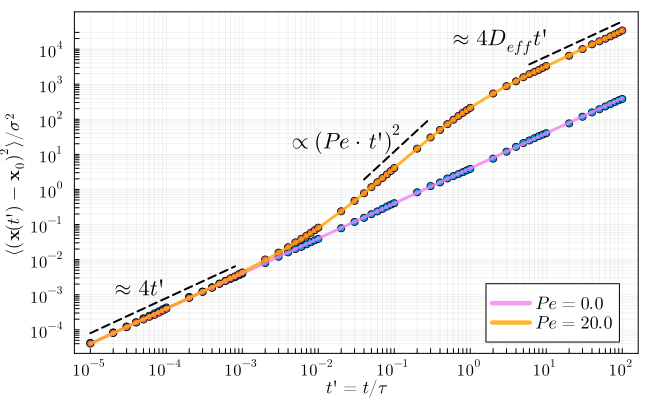

In [4]:
# ----------------------------------------------------------------------------------------
# Set the ticks of the MSD as a log10 scale. Label only values given as MSD = 10^{j}.
y_min = min(msd(log_times[1], Pe1), msd(log_times[1], Pe2))
y_max = max(msd(log_times[end], Pe1), msd(log_times[end], Pe2))
y_low_p = trunc(Int, log10(y_min)) - 1
y_high_p = trunc(Int, log10(y_max))
y_ticks = [round(i*10. ^(j), digits=abs(y_low_p)) for j ∈ y_low_p:y_high_p 
            for i ∈ 1:9 if y_min <= i*10. ^(j) <= y_max]
y_ticks_labels = [" " for _ ∈ 1:size(y_ticks, 1)]
y_powers = ["\$ 10^{$j} \$" for j ∈ y_low_p:y_high_p if y_min <= 10. ^(j) <= y_max]
y_ticks_labels[log10.(y_ticks) .== trunc.(Int, log10.(y_ticks))] .= y_powers
# ----------------------------------------------------------------------------------------


# General plot attributes.
kw = (; xticks=(log_times, my_xticks_labels),
        yticks=(y_ticks, y_ticks_labels),
        xlabel="\$ t' = t/\\tau \$",
        ylabel="\$ \\langle (\\mathbf{x}(t') - \\mathbf{x}_{0})^{2} \\rangle / \\sigma^{2} \$",
        xscale=:log10,
        yscale=:log10,
        legend=:bottomright,
        framestyle=:box,
        labelfontsize=12,
        legendfontsize=12,
        tickfontsize=11,
        size=(650, 400),
        dpi = 500
        )

# Plot of computed msd's
plot1c = plot(log_times, msd1, st=:scatter, label=""; kw...)
         plot!(log_times, msd2, st=:scatter, label="")

# Theoretical curves
plot!(log_times, msd.(log_times, Pe1), color="violet", lw=3, alpha=0.8, label="\$ Pe = $Pe1 \$")
plot!(log_times, msd.(log_times, Pe2), color="orange", lw=3, alpha=0.8, label="\$ Pe = $Pe2 \$")


# Regions of msd2 and annotations

## Brownian diffusion dominates
b_diffusion = log_times[0.95 .<= msd2./(4*log_times) .< 1.05]
b_midpoint = b_diffusion[size(b_diffusion, 1) ÷ 2 + 2]
plot!(b_diffusion, 2*4*b_diffusion, label="", ls=:dash, lw=2, color=:black)
annotate!(b_midpoint, 4*4*b_midpoint, text("\$ \\approx 4t' \$", :black, :right, 15))

## Self-propulsion randomization dominates
s_diffusion = log_times[0.8 .<= msd2./ ((Pe2 * log_times).^2) .<= 1.3]
s_midpoint = (s_diffusion[end] - s_diffusion[1])/2.
plot!(s_diffusion, 3*(Pe2*s_diffusion).^2, label="", ls=:dash, lw=2, color=:black)
annotate!(s_midpoint, 4*(Pe2*s_midpoint).^2, text("\$ \\propto (Pe \\cdot t')^{2} \$", :black, :right, 15))

## Both contribute to an effective diffusion
sb_diffusion = log_times[0.95 .<= msd2./ ((4 + 2 * (Pe2/q)^2)*log_times) .<= 1.05]
sb_midpoint = (sb_diffusion[end] - sb_diffusion[1])/2
plot!(sb_diffusion, 1.8*(4 + 2 * (Pe2/q)^2)*sb_diffusion, label="", ls=:dash, lw=2, color=:black)
annotate!(0.05*sb_midpoint, 2.7*(4 + 2 * (Pe2/q)^2)*sb_midpoint, 
            text("\$ \\approx 4 D_{eff} t' \$", :black, :top, 15))

# savefig(plot1c, "plot1c.png")

### 1.2.4. MSAD Plot <a class="anchor" id="section124"></a>

### [Contents](#Content)

In [ ]:
# ----------------------------------------------------------------------------------------
# Set the ticks of the MSAD as a log10 scale. Label only values given as MSAD = 10^{j}.
y_min = 2* q^2 * log_times[1]
y_max = 2* q^2 * log_times[end]
y_low_p = trunc(Int, log10(y_min)) - 1
y_high_p = trunc(Int, log10(y_max))
y_ticks = [round(i*10. ^(j), digits=abs(y_low_p)) for j ∈ y_low_p:y_high_p 
            for i ∈ 1:9 if y_min <= i*10. ^(j) <= y_max]
y_ticks_labels = [" " for _ ∈ 1:size(y_ticks, 1)]
y_powers = ["\$ 10^{$j} \$" for j ∈ y_low_p:y_high_p if y_min <= (10. ^j) <= y_max]
y_ticks_labels[log10.(y_ticks) .== trunc.(Int, log10.(y_ticks))] .= y_powers
# ----------------------------------------------------------------------------------------

kw = (; xticks=(log_times, my_xticks_labels),
        yticks=(y_ticks, y_ticks_labels),
        xlabel="\$ t' = t/\\tau \$",
        ylabel="\$ \\langle (\\varphi(t') - \\varphi_{0})^{2} \\rangle \$",
        xscale=:log10,
        yscale=:log10,
        legend=:topleft,
        framestyle=:box,
        labelfontsize=12,
        legendfontsize=12,
        tickfontsize=11,
        dpi = 500
        )

plot1d = plot(log_times, 2*(q^2)*log_times, label="\$ 2 q^{2} t' \$", 
        lw=3, 
        color=:red;
        kw...)
plot!(log_times, angles_msd1, st=:scatter, label="\$ Pe = $Pe1 \$",
        markershape=:circle, 
        markercolor=:white,
        markerstrokecolor=:dodgerblue,
        markerstrokewidth=2,
        markersize=6)
plot!(log_times, angles_msd2, st=:scatter, label="\$ Pe = $Pe2 \$",
        markershape=:rtriangle, 
        markercolor=:white,
        markerstrokecolor=:orange,
        markerstrokewidth=2,
        markersize=6)

# savefig(plot1d, "plot1d.png")